In [ ]:
import torch
from torch import nn
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from dataset import get_cifar10
from model import ResNet20

In [ ]:
def test(model, test_loader):
    model.to(device)
    model.eval()

    test_acc = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
        
            data = data.to(device)
            target = target.to(device)
        
            output = model(data)

            predictions = output.data.max(1)[1]
            test_acc += predictions.eq(target).sum().item()

        test_acc = test_acc / len(test_loader.dataset)
    return test_acc

In [ ]:
def prune(conv, n_clusters):
    kmeans = KMeans(n_clusters).fit(conv.weight.cpu().numpy().reshape(-1, 9))
    new_params = np.array([kmeans.cluster_centers_[label] for label in kmeans.labels_]).reshape(conv.weight.shape)
    conv.weight = nn.Parameter(torch.Tensor(new_params))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
_, _, test_loader = get_cifar10()

In [ ]:
model = ResNet20(3, 10)
model.load_state_dict(torch.load('best_model'))

In [ ]:
test(model, test_loader)

0.8983

In [ ]:
default_pruning_results = []
default_unique_convs = []
for n_clusters in [4, 8, 16, 32, 64, 128, 256, 512, 800, 1024, 1500, 2048]:
    model.load_state_dict((torch.load('best_model')))
    with torch.no_grad():
        tmp_n_clusters = min(n_clusters, 16*3)
        unique_filters += n_clusters1
        total_filters += 16*3

        prune(model.conv1, tmp_n_clusters)

        for conv in model.convs:
            n_filters = conv.weight.shape[0] * conv.weight.shape[1]
            tmp_n_clusters=min(n_clusters, n_filters)
            unique_filters += n_clusters1
            total_filters += n_filters

            prune(conv, tmp_n_clusters)
    default_pruning_results.append(test(model, test_loader))
    default_unique_convs.append(unique_filters / total_filters)

Text(0, 0.5, 'Accuracy')

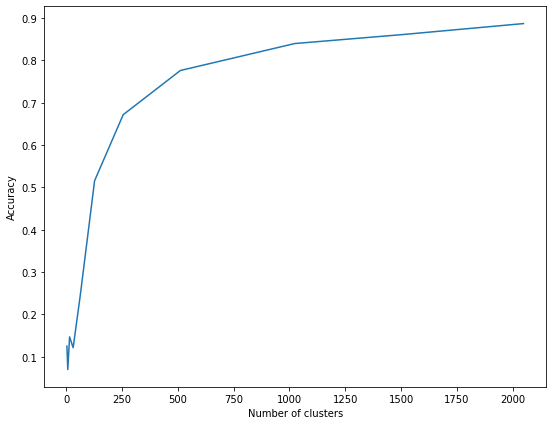

In [ ]:
plt.figure(figsize=(9, 7))
plt.plot([4, 8, 16, 32, 64, 128, 256, 512, 800, 1024, 1500, 2048], pruning_results)
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')

С увеличением количества кластеров точнось растет. 

Так как на разных сдоях разное количество фильторв, одно и то же количество кластеров по-разному влияет на слои. Например, на первом слое 48 фильтров, а на последних 4096, и при использовании 48 кластеров первый слой остается без изменения, в то время как на последних колчество уникальных сверток уменьшается в 85 раз. Как видно на графике, при количестве кластеров меньше 256, точность сильно уменьшается, но при этом на превых 7 слоях количество сверток 256 или меньше. Таким образом, при использовании одинакового числа кластеров на всех слоях, чтобы точность была высокой, первые слои придется оставить без изменений. Это может сказаться на точности модели после прунинга.

Далее я попробую использовать разное количество кластеров на разных слоях, чтобы доля уникальных сверток на каждом слое была одинаковой.

In [ ]:
fixed_unique_pruning_results = []
for prune_rate in [0.1 * i for i in range(1, 10)]:
    model.load_state_dict((torch.load('best_model')))
    with torch.no_grad():
        n_clusters = int(16*3 * (1 - prune_rate))
        prune(model.conv1, n_clusters)

        for conv in model.convs:
            n_clusters = int(conv.weight.shape[0] * conv.weight.shape[1] * (1 - prune_rate))
            prune(conv, n_clusters)
    fixed_unique_pruning_results.append(test(model, test_loader))

Сравнивать разные варианты прунинга я буду по графику точности в зависимости от доли уникальных сверток. В отличие от количества кластеров, доля уникальных сверток определена для случаев, когда на разных слоях разное количество кластеров. К тому же, количество параметров модели после прунинга линейно зависит от количества уникальных сверток.

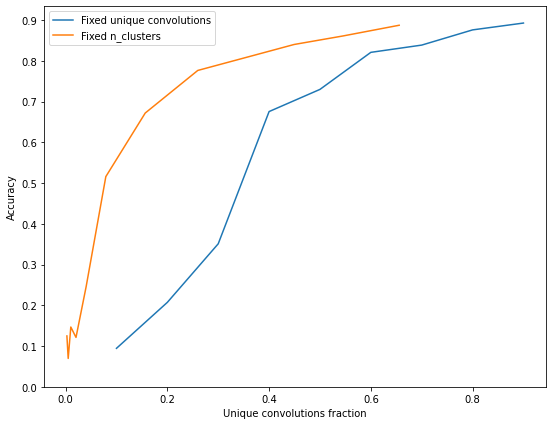

In [ ]:
plt.figure(figsize=(9, 7))
plt.plot([1 - 0.1 * i for i in range(1, 10)], fixed_unique_pruning_results, label='Fixed unique convolutions')
plt.plot(default_unique_convs, default_pruning_results, label='Fixed n_clusters')
plt.xlabel('Unique convolutions fraction')
plt.ylabel('Accuracy')
plt.yticks([0.1 * i for i in range(10)])
plt.legend()

Использование одинакового количества кластеров на всех слоях дает лучшую точность. 

Далее я сделаю на превых трех и последних двух слоях в два раза больше кластеров, чем на остальных, и сравню результаты.
Использование большего количества кластеров на первых слоях не даст никакого эффекта, если число кластеров и так больше размера слоя, но большее число кластеров на последних слоях может улучшить результаты.

In [ ]:
fixed_unique_different_first_and_last_pruning_results = []

fixed_unique_different_first_and_last_unique_convs = []
for prune_rate in [0.1 * i for i in range(1, 10)]:
    unique_filters = 0
    total_filters = 0
    model.load_state_dict((torch.load('best_model')))
    with torch.no_grad():
        n_clusters = int(16*3 * (1 - prune_rate/2))
        total_filters += 16*3
        unique_filters += n_clusters

        prune(model.conv1, n_clusters)

        for idx, conv in enumerate(model.convs):
            n_filters = conv.weight.shape[0] * conv.weight.shape[1]
            if idx < 2 or idx > len(model.convs) - 3:
                n_clusters = int(n_filters * (1 - prune_rate/2))
            else:
                n_clusters = int(n_filters * (1 - prune_rate))
            total_filters += n_filters
            unique_filters += n_clusters

            prune(conv, n_clusters)
    fixed_unique_different_first_and_last_pruning_results.append(test(model, test_loader))
    fixed_unique_different_first_and_last_unique_convs.append(unique_filters / total_filters)


In [ ]:
different_first_and_last_pruning_results = []
different_first_and_last_unique_convs = []
for n_clusters in [128, 256, 512, 800, 1024, 1500, 2048]:
    unique_filters = 0
    total_filters = 0
    model.load_state_dict((torch.load('best_model')))
    with torch.no_grad():
        tmp_n_clusters = min(n_clusters*2, 16*3)
        total_filters += 16*3
        unique_filters += tmp_n_clusters
        
        prune(model.conv1, tmp_n_clusters)

        for idx, conv in enumerate(model.convs):
            n_filters = conv.weight.shape[0] * conv.weight.shape[1]
            if idx < 2 or idx < len(model.convs) - 3:
                tmp_n_clusters=min(n_clusters * 2, n_filters)
            else:
                tmp_n_clusters=min(n_clusters, n_filters)
            total_filters += n_filters
            unique_filters += tmp_n_clusters

            prune(conv, tmp_n_clusters)
    different_first_and_last_pruning_results.append(test(model, test_loader))
    different_first_and_last_unique_convs.append(unique_filters / total_filters)

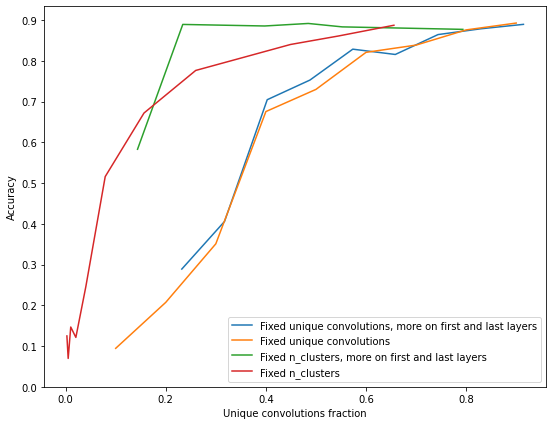

In [ ]:
plt.figure(figsize=(9, 7))
plt.plot(fixed_unique_different_first_and_last_unique_convs, fixed_unique_different_first_and_last_pruning_results, label='Fixed unique convolutions, more on first and last layers')
plt.plot([1 - 0.1 * i for i in range(1, 10)], fixed_unique_pruning_results, label='Fixed unique convolutions')
plt.plot(different_first_and_last_unique_convs, different_first_and_last_pruning_results, label='Fixed n_clusters, more on first and last layers')
plt.plot(default_unique_convs, default_pruning_results, label='Fixed n_clusters')
plt.xlabel('Unique convolutions fraction')
plt.ylabel('Accuracy')
plt.yticks([0.1 * i for i in range(10)])
plt.legend()

Лучше всего себя показал метод, использующий одинаковое число кластеров на всех слоях, кроме первых и последних. При высокой доле уникальных сверток он уступает другим методам, но его высокая точность сохраняется на очень большом интервале.

Результаты можно улучшить, найдя оптимальное количество слоев, на которых будет использоваться больше кластеров, и количество кластеров для этих слоев. 

Методы, оставляющие фиксированную долю уникальных сверток а каждом слое, выглядят менее перспективными. Возможно, если подобрать значения для каждого слоя, они покажут более высокую точность.
